In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [40]:
df_weather=pd.read_csv('data/airport_weather.gz',index_col=0,parse_dates=True)
#drop 
df_weather=df_weather.iloc[:,4:]


In [41]:
df_eba=pd.read_csv('data/EBA_time.gz',index_col=0,parse_dates=True)
df_region_eba=pd.read_csv('data/EBA_region_time.gz',index_col=0,parse_dates=True)

In [42]:
#Select temperature for Portland
msk=df_weather['city']=='Portland'
print(sum(msk))
df_temp=df_weather.loc[msk,'Temp']


24504


In [74]:
msk_p=df_temp>280
msk_n=df_temp<100

In [56]:
msk=df_eba.columns.str.contains('Portland')
df_pdx=df_eba.loc[:,msk]


### Anomaly Detection

A quick look at the portland data suggests that there are both real outliers, and ones from errors in the data process (100x surrounding values).  

Tests should be for total interchange = 0, and 
Demand=Net Gen - Net Interchange

In [70]:
# def clean_df(df):
#     """clean_df(df)
#     Replace extreme values with the value on either side. 
#     Detect extreme values when the finite difference exceeds the variance? 
#     But this coul
df_pdx.iloc[:,[0,2,3]]

,"Demand for Portland General Electric Company (PGE), Hourly","Total net actual interchange for Portland General Electric Company (PGE), Hourly","Net generation for Portland General Electric Company (PGE), Hourly"
2015-07-01 00:00:00,3648.0,-1231.0,2417.0
2015-07-01 01:00:00,3658.0,-1275.0,2383.0
2015-07-01 02:00:00,3608.0,-1375.0,2233.0
2015-07-01 03:00:00,3493.0,-1531.0,1962.0
2015-07-01 04:00:00,3374.0,-1361.0,2013.0
2015-07-01 05:00:00,3218.0,-1305.0,1913.0
2015-07-01 06:00:00,2974.0,-1226.0,1748.0
2015-07-01 07:00:00,2608.0,-961.0,1647.0
2015-07-01 08:00:00,2332.0,-708.0,1624.0
2015-07-01 09:00:00,2143.0,-663.0,1480.0


In [136]:
%pdb

Automatic pdb calling has been turned ON


<IPython.core.display.Javascript object>


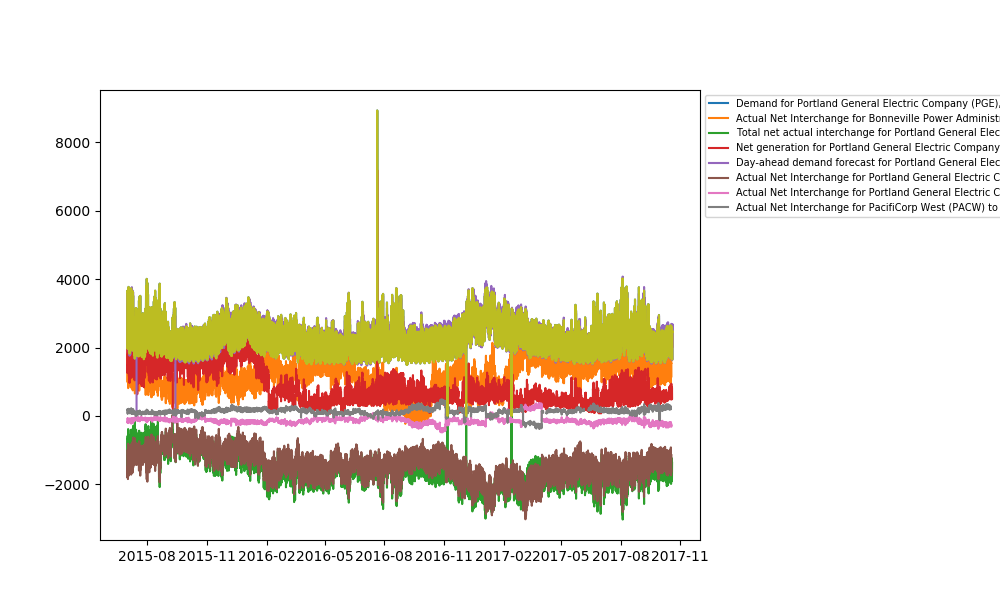

In [72]:
vnew=[735567.85,736564,0,10000]
fig=plt.figure(figsize=(10,6))
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
ax.plot(df_pdx)
ax.legend(df_pdx.columns.values,loc='upper left',bbox_to_anchor=(1,1),prop={'size':7})

In [ ]:
#Check that the energy is balanced for this small subset: Demand = Net Generation - Net Interchange.
#Seems to not be true.  

<IPython.core.display.Javascript object>


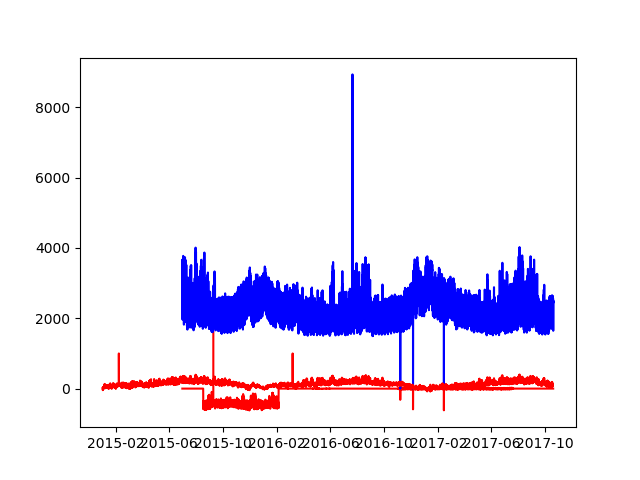

In [78]:
dem=df_pdx.iloc[:,0]
gen=df_pdx.iloc[:,2]
net=df_pdx.iloc[:,3]
plt.figure()
plt.plot(dem-(-gen+net),'r')

In [90]:
?pd.DataFrame([dem,df_temp],columns=['Demand','Temp'])
#plt.figure()
#plt.plot(df)

In [89]:
print(df)

                                                            Demand  Temp
Demand for Portland General Electric Company (PGE), Hourly     NaN   NaN
Temp                                                           NaN   NaN
